<a href="https://colab.research.google.com/github/AdityaPunetha/ML-Projects/blob/main/TensorFlow-Fashion-MNIST-GAN/improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
from numpy.random import randint, randn
from numpy import zeros,ones
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2DTranspose, ReLU
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import os

%matplotlib inline

# Load Data

In [2]:
(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


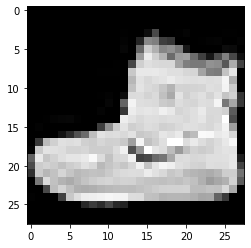

In [3]:
plt.imshow(trainX[0], cmap='gray')

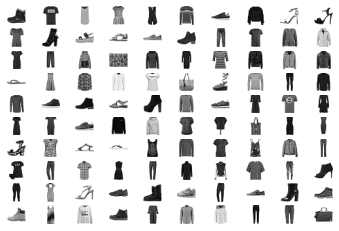

In [4]:
for i in range(100):
  	plt.subplot(10, 10, 1 + i)
  	plt.axis('off')
  	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [5]:
in_shape = (28,28,1)

# Build Discriminator

In [6]:
discriminator = Sequential()
    
    # First Conv Block
discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
discriminator.add(LeakyReLU(0.2))
    
    # Second Conv Block
discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))
    
    # Flatten then pass to dense layer
discriminator.add(Flatten())
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))

In [7]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

In [8]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6

# Define Generator

In [9]:
latent_size = 128

In [10]:
generator = Sequential()
    
generator.add(Dense(7*7*128, input_dim=latent_size))
generator.add(ReLU())
generator.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(ReLU())
    
    # Upsampling block 2 
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(ReLU())
    
    # Conv layer to get to one channel
generator.add(Conv2D(1, (7,7), activation='tanh', padding='same'))

In [11]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 re_lu (ReLU)                (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

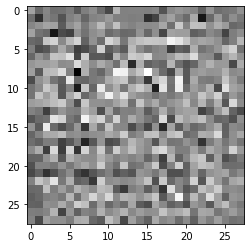

In [12]:
sample_generated_image = generator(randn(1,latent_size))
plt.imshow(np.squeeze(sample_generated_image[0]),cmap = 'gray')

# Define GAN

In [13]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# Train discriminator

In [14]:
batch_size = 100

In [15]:
X = np.expand_dims(trainX, axis=-1)
X = X.astype('float32')
X = (X - 127.5) / 127.5

In [16]:
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	x = dataset[ix]
	return x

In [17]:
def train_discriminator(images):
  real_labels = ones((batch_size,1))
  fake_labels = zeros((batch_size,1))

  d_loss_real, _ = discriminator.train_on_batch(images,real_labels)

  generated_images = generator(randn(batch_size,latent_size))

  d_loss_fake, _ = discriminator.train_on_batch(generated_images,fake_labels)

  d_loss = d_loss_fake + d_loss_real

  return d_loss, d_loss_fake, d_loss_real

# Training the model

In [18]:
gan_model = define_gan(generator, discriminator)

In [19]:
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1339905   
                                                                 
 sequential (Sequential)     (None, 1)                 155137    
                                                                 
Total params: 1,495,042
Trainable params: 1,339,905
Non-trainable params: 155,137
_________________________________________________________________


In [20]:
bat_per_epo = int(X.shape[0] / batch_size)

In [ ]:
num_epochs = 50
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i in range(bat_per_epo):
      X_real = generate_real_samples(X, batch_size)

      d_loss, d_loss_fake, d_loss_real = train_discriminator(X_real)

      g_loss = gan_model.train_on_batch(randn(batch_size,latent_size), ones((batch_size, 1)))

      if (i+1) % 200 == 0:
          d_losses.append(d_loss)
          g_losses.append(g_loss)

          print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(epoch, num_epochs, i+1, bat_per_epo, d_loss, g_loss))